## Load and filter classes

In [1]:
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]
df = pd.read_csv(classes_file)
df.set_index("index", inplace=True)
selected_classes_indexes = df.index[df['display_name'].isin(selected_classes)].tolist()
print(selected_classes_indexes)

[53, 68, 71, 74, 111, 308, 327, 334, 396, 420]


In [4]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def extract_features(dataset_dir):
    X = []
    y = []
    recordset = os.listdir(dataset_dir)
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)    
        for raw_record in raw_dataset.take(1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
            # print(labels)

            for label in labels:
                if label in selected_classes_indexes:
                    # video = example.features.feature['video_id'].bytes_list.value[0].decode("utf-8")
                    # start = example.features.feature['start_time_seconds'].float_list.value[0]
                    # end = example.features.feature['end_time_seconds'].float_list.value[0]
                    # print(f"Video: {video}")
                    # print(f"Duration: {end-start} seconds")
                    
                    labels_detected = set(labels).intersection(set(selected_classes_indexes))
                    # print(f"Labels: ", labels_detected)
                    
                    example_seq = tf.train.SequenceExample()
                    example_seq.ParseFromString(raw_record.numpy())
                    
                    try:
                        i=0
                        feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                        while True:
                            hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                            features_array = [int(hex_features[k:k+2],16) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                            X.append(features_array)
                            y.append(list(labels_detected))
                            i += 1
                    except IndexError as ie:
                            #FeatureList does not have length, so we read until the end
                            continue
                            
    X = np.array(X)/255
    y = np.array(y, dtype=object)
    
    # Apply OneHotEncodig to ground truth
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)

    # We need to add at least one dimension to our X   
    X = X.reshape(X.shape[0], 128, 1)
    return X,y

In [5]:
# Extract data for training
X_train, y_train = extract_features("../dataset/audioset_v1_embeddings/bal_train/")

print(X_train.shape, y_train.shape)

(1978, 128, 1) (1978, 10)


In [6]:
# Extract also X and y for validation
X_val, y_val = extract_features("../dataset/audioset_v1_embeddings/eval/")
print(X_val.shape, y_val.shape)

(2233, 128, 1) (2233, 10)


C:\Users\jm250119\AppData\Local\Temp\ipykernel_10968\3849986614.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


# Define neural network for classification
We need a neural network with 128 inputs and 10 outputs (one for each audio class). As each audio could be multilabelled, it is not recommended to use softmax as output layer but sigmoid (https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

model = Sequential([
    #Conv1D(32, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    Conv1D(128, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    MaxPool1D(pool_size=2, name="maxpool1"),
    
    #Conv1D(64, 3, padding="same", activation="relu", name="conv1D_1"),
    Conv1D(128, 3, padding="same", activation="relu", name="conv1D_1"),
    MaxPool1D(pool_size=2, name="maxpool2"),
    
    #Conv1D(128, 3, padding="same", activation="relu", name="conv1D_2"),
    Conv1D(64, 3, padding="same", activation="relu", name="conv1D_2"),
    MaxPool1D(pool_size=2, name="maxpool3"),
    
    # Conv1D(256, 3, padding="same", activation="relu", name="conv1D_3"),
    # MaxPool1D(pool_size=2, name="maxpool4"),
      
    Flatten(name="flatten"),
    Dense(1024, activation="relu", name="dense"),
    
    Dense(len(selected_classes_indexes), activation="sigmoid", name="output")
])

opt = Adam(learning_rate=0.0001)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv1D)              (None, 128, 128)          512       
                                                                 
 maxpool1 (MaxPooling1D)     (None, 64, 128)           0         
                                                                 
 conv1D_1 (Conv1D)           (None, 64, 128)           49280     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 32, 128)           0         
                                                                 
 conv1D_2 (Conv1D)           (None, 32, 64)            24640     
                                                                 
 maxpool3 (MaxPooling1D)     (None, 16, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

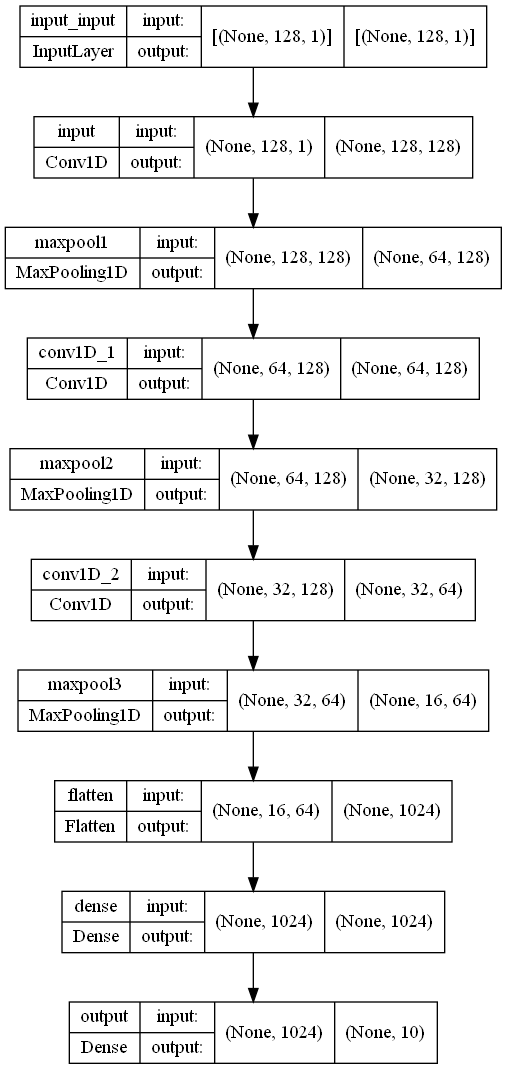

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [9]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 3s 39ms/step - loss: 2.1062 - accuracy: 0.2856 - val_loss: 2.1903 - val_accuracy: 0.2808
Epoch 2/20
62/62 [==============================] - 2s 33ms/step - loss: 2.0199 - accuracy: 0.3407 - val_loss: 2.1549 - val_accuracy: 0.2575
Epoch 3/20
62/62 [==============================] - 2s 35ms/step - loss: 1.9331 - accuracy: 0.3589 - val_loss: 2.0519 - val_accuracy: 0.3077
Epoch 4/20
62/62 [==============================] - 2s 34ms/step - loss: 1.7516 - accuracy: 0.4029 - val_loss: 1.8854 - val_accuracy: 0.3475
Epoch 5/20
62/62 [==============================] - 2s 33ms/step - loss: 1.5314 - accuracy: 0.4818 - val_loss: 1.6937 - val_accuracy: 0.4465
Epoch 6/20
62/62 [==============================] - 2s 35ms/step - loss: 1.3184 - accuracy: 0.5637 - val_loss: 1.5929 - val_accuracy: 0.4877
Epoch 7/20
62/62 [==============================] - 2s 34ms/step - loss: 1.1693 - accuracy: 0.6102 - val_loss: 1.5272 - val_accuracy: 0.4944
Epoch 8/20
62

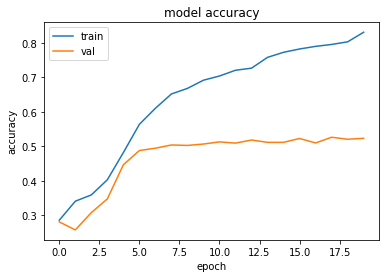

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

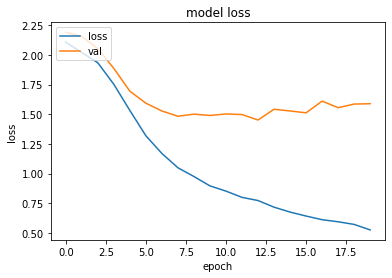

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Resizing, Normalization, Conv2D, MaxPooling2D, Dropout

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=X_train)

model2 = Sequential([
    input_shape=X_train[0].shape,
    # Downsample the input.
    # Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv1D(32, 3, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    MaxPool1D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes_indexes)),
])

model2.summary()

In [ ]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

In [ ]:
# Esta red no funciona bien, se descarta

In [18]:
import keras

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model2 = build_model(X_train[0].shape, len(selected_classes_indexes))

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 128, 16)      64          ['input[0][0]']                  
                                                                                                  
 activation_13 (Activation)     (None, 128, 16)      0           ['conv1d_19[0][0]']              
                                                                                                  
 conv1d_20 (Conv1D)             (None, 128, 16)      784         ['activation_13[0][0]']          
                                                                                            

 conv1d_32 (Conv1D)             (None, 8, 128)       16512       ['max_pooling1d_8[0][0]']        
                                                                                                  
 add_9 (Add)                    (None, 8, 128)       0           ['conv1d_35[0][0]',              
                                                                  'conv1d_32[0][0]']              
                                                                                                  
 activation_25 (Activation)     (None, 8, 128)       0           ['add_9[0][0]']                  
                                                                                                  
 max_pooling1d_9 (MaxPooling1D)  (None, 4, 128)      0           ['activation_25[0][0]']          
                                                                                                  
 average_pooling1d_1 (AveragePo  (None, 1, 128)      0           ['max_pooling1d_9[0][0]']        
 oling1D) 

In [19]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 5s 49ms/step - loss: 2.1116 - accuracy: 0.2204 - val_loss: 2.2052 - val_accuracy: 0.2373
Epoch 2/20
62/62 [==============================] - 3s 48ms/step - loss: 2.0731 - accuracy: 0.2422 - val_loss: 2.1975 - val_accuracy: 0.2365
Epoch 3/20
62/62 [==============================] - 2s 39ms/step - loss: 2.0666 - accuracy: 0.2720 - val_loss: 2.2087 - val_accuracy: 0.1966
Epoch 4/20
62/62 [==============================] - 3s 47ms/step - loss: 2.0539 - accuracy: 0.2786 - val_loss: 2.1911 - val_accuracy: 0.1899
Epoch 5/20
62/62 [==============================] - 3s 46ms/step - loss: 2.0219 - accuracy: 0.2856 - val_loss: 2.2018 - val_accuracy: 0.2091
Epoch 6/20
62/62 [==============================] - 3s 42ms/step - loss: 1.9546 - accuracy: 0.3109 - val_loss: 2.0605 - val_accuracy: 0.2714
Epoch 7/20
62/62 [==============================] - 3s 44ms/step - loss: 1.7727 - accuracy: 0.3670 - val_loss: 1.8604 - val_accuracy: 0.3336
Epoch 8/20
62

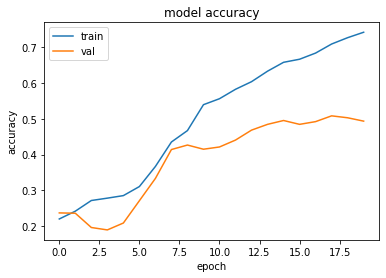

In [20]:
from matplotlib import pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(X_train[0].shape, name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)
    x = keras.layers.Flatten()(x)

    outputs = keras.layers.Dense(len(selected_classes_indexes), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="sound_recognition")

    model.compile(
        optimizer=Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model3 = build_and_compile_model()
model3.summary()

Model: "sound_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 128, 1)]          0         
                                                                 
 dense_1 (Dense)             (None, 128, 256)          512       
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 dense_2 (Dense)             (None, 128, 384)          98688     
                                                                 
 dropout_2 (Dropout)         (None, 128, 384)          0         
                                                                 
 dense_3 (Dense)             (None, 128, 192)          73920     
                                                                 
 dropout_3 (Dropout)         (None, 128, 192)    

In [27]:
history3 = model3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 12s 177ms/step - loss: 2.2041 - accuracy: 0.2265 - auc: 0.6849 - val_loss: 2.1984 - val_accuracy: 0.2029 - val_auc: 0.6737
Epoch 2/20
62/62 [==============================] - 11s 172ms/step - loss: 2.0344 - accuracy: 0.3023 - auc: 0.7339 - val_loss: 2.1449 - val_accuracy: 0.2539 - val_auc: 0.6945
Epoch 3/20
62/62 [==============================] - 10s 167ms/step - loss: 1.9519 - accuracy: 0.3620 - auc: 0.7721 - val_loss: 2.0860 - val_accuracy: 0.2915 - val_auc: 0.7230
Epoch 4/20
62/62 [==============================] - 18s 285ms/step - loss: 1.8255 - accuracy: 0.4024 - auc: 0.8099 - val_loss: 1.9597 - val_accuracy: 0.3475 - val_auc: 0.7583
Epoch 5/20
62/62 [==============================] - 21s 334ms/step - loss: 1.5836 - accuracy: 0.4869 - auc: 0.8621 - val_loss: 1.6917 - val_accuracy: 0.4617 - val_auc: 0.8327
Epoch 6/20
62/62 [==============================] - 18s 289ms/step - loss: 1.2329 - accuracy: 0.6102 - auc: 0.9281 - val_loss

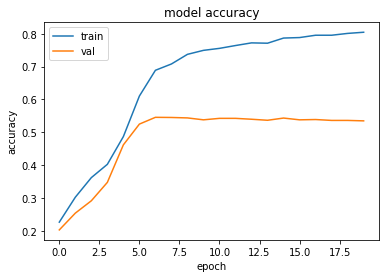

In [28]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()